# **Working memory training**: Static modularity analysis 

**Last edited:** 12-02-2019

Step 0: Loading libraries
-----------------------

In [2]:
# Loading packages
library(psych)
library(tidyverse)
library(data.table)
library(nlme)
library(broom)
library(Hmisc)

# Customizing theme for plotting
theme_training <- theme_bw() + theme(axis.text.y = element_text(size=25, colour='#262626ff'),
          axis.text.x = element_text(size=25, colour='#262626ff'),
          axis.title.y = element_text(size=25, colour='#262626ff'),
          axis.title.x  = element_text(size=25, colour='#262626ff'),
          plot.title = element_text(hjust=0.5, size=25),
          panel.grid.major = element_blank(), 
          panel.grid.minor = element_blank(),
          axis.line = element_line(colour="#262626ff"),
          panel.border = element_rect(colour = "#262626ff", fill=NA, size=1.8),
          panel.background = element_rect(fill="transparent",colour=NA),
          plot.background = element_rect(fill="transparent",colour=NA),
          legend.key = element_rect(fill= "transparent", colour="transparent"),
          strip.background =element_rect(fill="transparent", colour=NA),
          strip.text = element_text(size=25),
          axis.ticks = element_line(colour="#262626ff", size=1, 2),
          axis.ticks.length = unit(.15, "cm"),
          aspect.ratio = 1,
          )

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.0.0     ✔ purrr   0.2.5
✔ tibble  1.4.2     ✔ dplyr   0.7.6
✔ tidyr   0.8.1     ✔ stringr 1.3.1
✔ readr   1.1.1     ✔ forcats 0.3.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ ggplot2::%+%()   masks psych::%+%()
✖ ggplot2::alpha() masks psych::alpha()
✖ dplyr::filter()  masks stats::filter()
✖ dplyr::lag()     masks stats::lag()

Attaching package: ‘data.table’

The following objects are masked from ‘package:dplyr’:

    between, first, last

The following object is masked from ‘package:purrr’:

    transpose


Attaching package: ‘nlme’

The following object is masked from ‘package:dplyr’:

    collapse

Loading required package: lattice
Loading required package: survival
Loading required package: Formula

Attaching package: ‘Hmisc’

The following objects are masked from ‘package:dplyr’:

    src, summarize

The following object is masked from ‘package:psy

Step 1: Preparing data
-----------------------

In [3]:
# Setting working directory
setwd("~/Dropbox/Projects/LearningBrain/")

Q <- read.csv('data/neuroimaging/03-modularity/static/Q_normalized_power_tidy.csv')

# Preparing data
Q$Session <- factor(Q$Session, levels = c('Naive', 'Early', 'Middle', 'Late'))
Q$Condition <- factor(Q$Condition, levels = c('Rest', '1-back', '2-back'))
Q$Group <- factor(Q$Group, levels = c('Experimental', 'Control'))

Q$Task[Q$Condition == '1-back'] <- 'N-back'
Q$Task[Q$Condition == '2-back'] <- 'N-back'
Q$Task[Q$Condition == 'Rest'] <- 'Rest'

# Subjects to excluede
dualnback_motion = c('sub-13', 'sub-21', 'sub-23', 'sub-50') # higly motion subjects in one of four sessions
rest_motion = c('sub-21', 'sub-46', 'sub-47') # higly motion subjects in one of four sessions / missing data(20-44)
rest_missing = c('sub-20', 'sub-44')

first_session_motion = 'sub-21' # subject with highly motion on first session

# Setting contrasts
rest_vs_dual <- c(-2, 1, 1)
back2_vs_back1 <- c(0, -1, 1) 

contrasts(Q$Condition) <- cbind(rest_vs_dual, back2_vs_back1)
head(Q)

Subject,Group,Session,Condition,Q_norm,Task
sub-01,Control,Naive,Rest,3.325508,Rest
sub-01,Control,Naive,1-back,2.116409,N-back
sub-01,Control,Naive,2-back,2.210752,N-back
sub-01,Control,Early,Rest,2.737067,Rest
sub-01,Control,Early,1-back,2.313354,N-back
sub-01,Control,Early,2-back,2.634171,N-back


Step 2: Multilevel modeling (static modularity differences during first session)
--------------------------------

In [48]:
naive <- Q %>% filter(Session == 'Naive') %>% filter(Subject != 'sub-21') 

baseline <- lme(Q_norm ~ 1, random = ~ 1|Subject/Condition, data = naive, method = 'ML',  control = list(opt = "optim"), na.action = na.exclude)
condition <- update(baseline, .~. + Condition)

anova(baseline, condition)

,call,Model,df,AIC,BIC,logLik,Test,L.Ratio,p-value
baseline,"lme.formula(fixed = Q_norm ~ 1, data = naive, random = ~1 | Subject/Condition, method = ""ML"", na.action = na.exclude, control = list(opt = ""optim""))",1,4,183.0091,194.6302,-87.50454,,NA,NA
condition,"lme.formula(fixed = Q_norm ~ Condition, data = naive, random = ~1 | Subject/Condition, method = ""ML"", na.action = na.exclude, control = list(opt = ""optim""))",2,6,102.8763,120.3080,-45.43817,1 vs 2,84.13273,5.380353e-19


In [49]:
summary(condition)

Linear mixed-effects model fit by maximum likelihood
 Data: naive 
       AIC     BIC    logLik
  102.8763 120.308 -45.43817

Random effects:
 Formula: ~1 | Subject
        (Intercept)
StdDev:   0.2361972

 Formula: ~1 | Condition %in% Subject
        (Intercept)  Residual
StdDev:   0.2583928 0.1080257

Fixed effects: Q_norm ~ Condition 
                             Value  Std.Error DF   t-value p-value
(Intercept)              3.0640507 0.04315263 88  71.00496  0.0000
Conditionrest_vs_dual   -0.1960397 0.01723681 88 -11.37332  0.0000
Conditionback2_vs_back1 -0.0776212 0.02985502 88  -2.59994  0.0109
 Correlation: 
                        (Intr) Cndt__
Conditionrest_vs_dual   0            
Conditionback2_vs_back1 0      0     

Standardized Within-Group Residuals:
        Min          Q1         Med          Q3         Max 
-0.91998882 -0.25088719 -0.02666615  0.23786006  0.86130427 

Number of Observations: 135
Number of Groups: 
               Subject Condition %in% Subject 
        

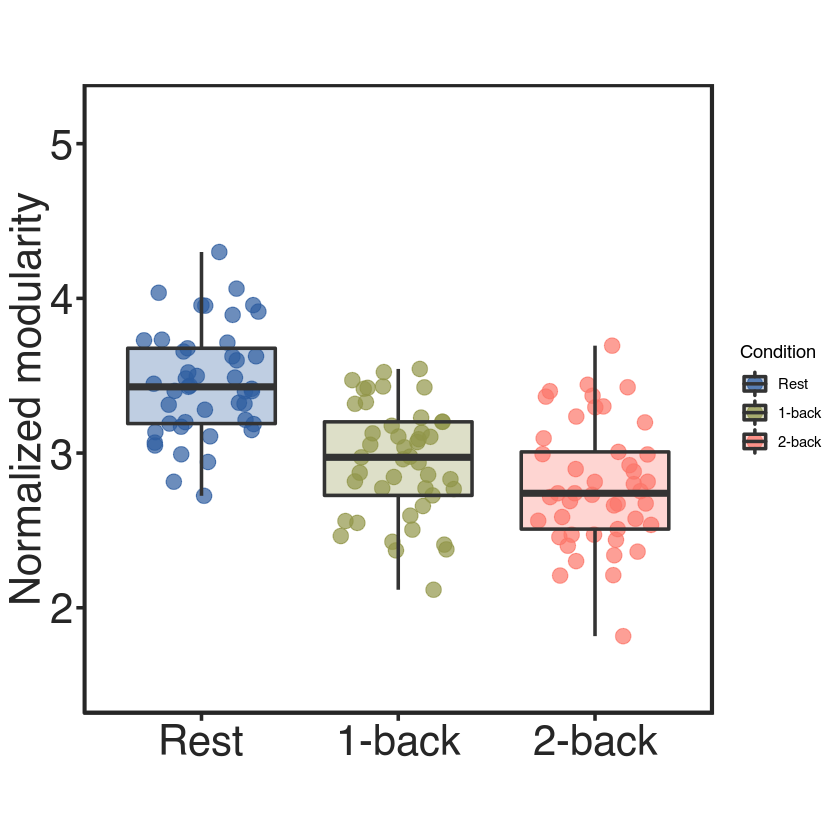

In [37]:
p <- ggplot(naive, aes(x = Condition, y = Q_norm, fill = Condition)) + 
    scale_colour_manual(values=c('#2e5d9f', '#919649', '#fc766a')) +
    scale_fill_manual(values=c('#2e5d9f', '#919649', '#fc766a')) +
    geom_jitter(aes(col = Condition),  alpha = 0.7, size = 4, width = 0.3, height = 0.0) +
    geom_boxplot(size = 1,  alpha = 0.3, outlier.shape = NA) +
    xlab('') +
    ylim(1.5, 5.2) +
    ylab('Normalized modularity') +
    ggtitle('') + 
    theme_training

p

ggsave("figures/Figure_modu_norm_naive.pdf", plot = p, width = 8, height = 6, dpi = 300)  

Step 3: Multilevel modeling (static modularity changes during training)
--------------------------------

In [6]:
Q_clean <- Q %>% filter(Condition != 'Rest') %>% filter(!(Subject %in% dualnback_motion)) 
contrasts(Q_clean$Condition) <- cbind(back2_vs_back1)

baseline <- lme(Q_norm ~ 1, random = ~ 1|Subject/Session/Condition, data = Q_clean, method = 'ML',  control = list(opt = "optim"), na.action = na.exclude)
condition <- update(baseline, .~. + Condition)
session <- update(condition, .~. + Session)
group <- update(session, .~. + Group)

condition_session <- update(group, .~. + Condition:Session)
condition_group <- update(condition_session, .~. + Condition:Group)
session_group <- update(condition_group, .~. + Session:Group)
condition_session_group <- update(session_group, .~. + Condition:Session:Group)

anova(baseline, condition, session, group, condition_session, condition_group, session_group, condition_session_group)
summary(session)

Warning message:
“contrasts dropped from factor Condition due to missing levels”Warning message:
“contrasts dropped from factor Condition due to missing levels”Warning message:
“contrasts dropped from factor Condition due to missing levels”Warning message:
“contrasts dropped from factor Condition due to missing levels”Warning message:
“contrasts dropped from factor Condition due to missing levels”Warning message:
“contrasts dropped from factor Condition due to missing levels”Warning message:
“contrasts dropped from factor Condition due to missing levels”Warning message:
“contrasts dropped from factor Condition due to missing levels”

,call,Model,df,AIC,BIC,logLik,Test,L.Ratio,p-value
baseline,"lme.formula(fixed = Q_norm ~ 1, data = Q_clean, random = ~1 | Subject/Session/Condition, method = ""ML"", na.action = na.exclude, control = list(opt = ""optim""))",1,5,261.3236,280.4091,-125.66178,,NA,NA
condition,"lme.formula(fixed = Q_norm ~ Condition, data = Q_clean, random = ~1 | Subject/Session/Condition, method = ""ML"", na.action = na.exclude, control = list(opt = ""optim""))",2,6,221.4958,244.3984,-104.74789,1 vs 2,41.8277723,9.967750e-11
session,"lme.formula(fixed = Q_norm ~ Condition + Session, data = Q_clean, random = ~1 | Subject/Session/Condition, method = ""ML"", na.action = na.exclude, control = list(opt = ""optim""))",3,9,208.0869,242.4409,-95.04343,2 vs 3,19.4089185,2.250120e-04
group,"lme.formula(fixed = Q_norm ~ Condition + Session + Group, data = Q_clean, random = ~1 | Subject/Session/Condition, method = ""ML"", na.action = na.exclude, control = list(opt = ""optim""))",4,10,203.4609,241.6320,-91.73044,3 vs 4,6.6259858,1.005015e-02
condition_session,"lme.formula(fixed = Q_norm ~ Condition + Session + Group + Condition:Session, data = Q_clean, random = ~1 | Subject/Session/Condition, method = ""ML"", na.action = na.exclude, control = list(opt = ""optim""))",5,13,207.4576,257.0801,-90.72881,4 vs 5,2.0032573,5.717309e-01
condition_group,"lme.formula(fixed = Q_norm ~ Condition + Session + Group + Condition:Session + Condition:Group, data = Q_clean, random = ~1 | Subject/Session/Condition, method = ""ML"", na.action = na.exclude, control = list(opt = ""optim""))",6,14,208.9622,262.4018,-90.48112,5 vs 6,0.4953792,4.815375e-01
session_group,"lme.formula(fixed = Q_norm ~ Condition + Session + Group + Condition:Session + Condition:Group + Session:Group, data = Q_clean, random = ~1 | Subject/Session/Condition, method = ""ML"", na.action = na.exclude, control = list(opt = ""optim""))",7,17,213.5163,278.4071,-89.75813,6 vs 7,1.4459876,6.947913e-01
condition_session_group,"lme.formula(fixed = Q_norm ~ Condition + Session + Group + Condition:Session + Condition:Group + Session:Group + Condition:Session:Group, data = Q_clean, random = ~1 | Subject/Session/Condition, method = ""ML"", na.action = na.exclude, control = list(opt = ""optim""))",8,20,218.0174,294.3597,-89.00872,7 vs 8,1.4988058,6.825460e-01


Linear mixed-effects model fit by maximum likelihood
 Data: Q_clean 
       AIC      BIC    logLik
  208.0869 242.4409 -95.04343

Random effects:
 Formula: ~1 | Subject
        (Intercept)
StdDev:   0.2625963

 Formula: ~1 | Session %in% Subject
        (Intercept)
StdDev:   0.2041154

 Formula: ~1 | Condition %in% Session %in% Subject
        (Intercept)   Residual
StdDev:   0.2076227 0.09559053

Fixed effects: Q_norm ~ Condition + Session 
                     Value  Std.Error  DF  t-value p-value
(Intercept)      2.9413243 0.05884546 167 49.98388  0.0000
Condition2-back -0.1718705 0.02512681 167 -6.84013  0.0000
SessionEarly     0.0924074 0.05724193 123  1.61433  0.1090
SessionMiddle    0.1631188 0.05724193 123  2.84964  0.0051
SessionLate      0.2504456 0.05724193 123  4.37521  0.0000
 Correlation: 
                (Intr) Cndt2- SssnEr SssnMd
Condition2-back -0.213                     
SessionEarly    -0.486  0.000              
SessionMiddle   -0.486  0.000  0.500       
SessionLa

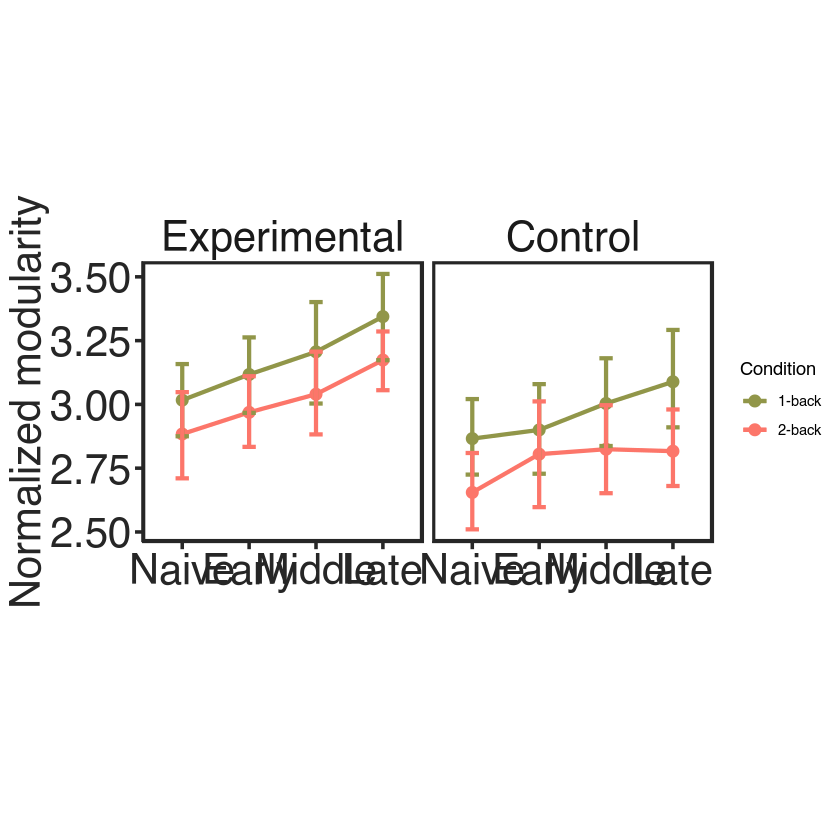

In [5]:
p <- ggplot(Q_clean, aes(x = Session, y = Q_norm, color = Condition)) +
    stat_summary(fun.y = mean, geom = 'point', size = 3) +
    stat_summary(fun.y = mean, geom = 'line', size = 1.2, aes(group = Condition)) +
    stat_summary(fun.data = mean_cl_boot, geom = 'errorbar', width = 0.2, size = 1.2) +
    scale_colour_manual(values=c('#919649', '#fc766a')) +
    ylab('Normalized modularity') +
    facet_wrap(~Group) +
    xlab(' ') +
    theme_training
p

ggsave("figures/Figure_modu_power_groups.pdf", plot = p, width = 12, height = 6, dpi = 300)  

In [5]:
experimental <- Q_clean %>% filter(Group == 'Experimental')
control <- Q_clean %>% filter(Group == 'Control') 
head(experimental)

Subject,Group,Session,Condition,Q_norm,Task
sub-05,Experimental,Naive,1-back,3.201963,N-back
sub-05,Experimental,Naive,2-back,2.689509,N-back
sub-05,Experimental,Early,1-back,3.222335,N-back
sub-05,Experimental,Early,2-back,3.359992,N-back
sub-05,Experimental,Middle,1-back,2.969649,N-back
sub-05,Experimental,Middle,2-back,3.243521,N-back


Step 4: T-tests (Naive vs. Late comparison)
---------------------------

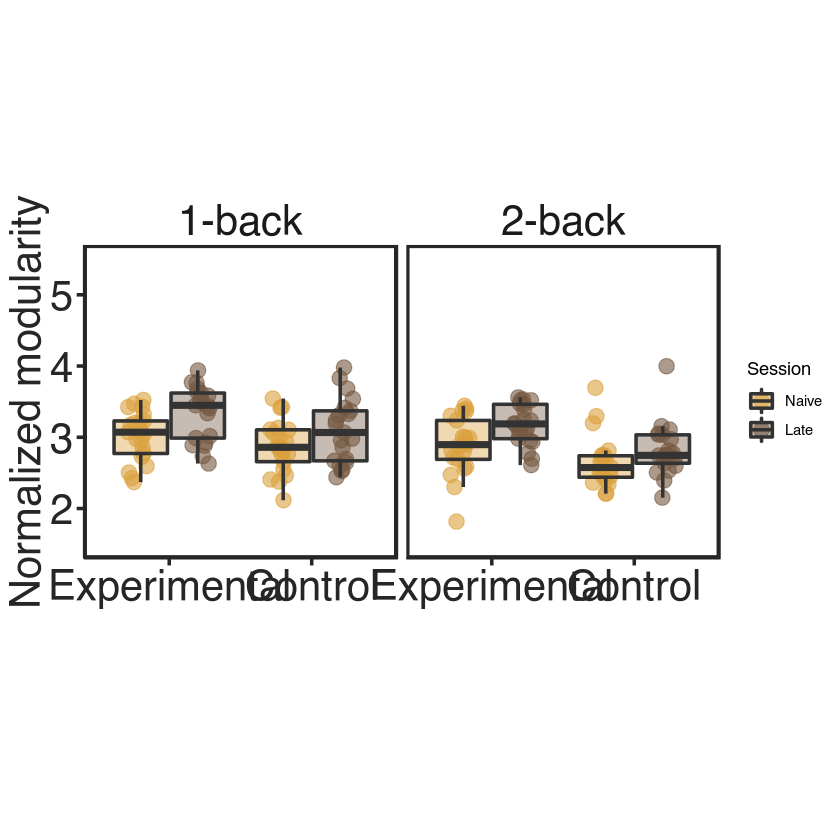

In [18]:
p <- Q_clean %>% filter(Session %in% c('Naive', 'Late')) %>%
    ggplot(aes(x = Group, y = Q_norm, fill = Session)) + 
    geom_point(aes(col = Session), position=position_jitterdodge(dodge.width=0.9), alpha = 0.6, size = 4) +
    geom_boxplot(alpha = 0.4, outlier.shape = NA, position=position_dodge(width=0.8), size = 1) + 
    scale_fill_manual(values=c('#daa03d', '#755841')) +
    scale_color_manual(values=c('#daa03d', '#755841')) +
    facet_wrap(~Condition) +
    ylim(1.5, 5.5) +
    ylab('Normalized modularity') +
    xlab('') + 
    theme_training

p

ggsave("figures/Figure_modu_power_ttests.pdf", plot = p, width = 12, height = 6, dpi = 300)  


In [5]:
library(plyr)

Q_nl <- Q_clean %>% filter(Session %in% c('Naive', 'Late'))
table <-  ddply(Q_nl, c('Condition', 'Session', 'Group'), summarise, 
                              N = length(Q_norm),
                              mean = mean(Q_norm),
                              sd = sd(Q_norm),
                              se = sd/sqrt(N)
                )

table

limits <- aes(ymax = table$mean + table$se,
              ymin = table$mean - table$se)


------------------------------------------------------------------------------
You have loaded plyr after dplyr - this is likely to cause problems.
If you need functions from both plyr and dplyr, please load plyr first, then dplyr:
library(plyr); library(dplyr)
------------------------------------------------------------------------------

Attaching package: ‘plyr’

The following objects are masked from ‘package:Hmisc’:

    is.discrete, summarize

The following objects are masked from ‘package:dplyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize

The following object is masked from ‘package:purrr’:

    compact



Condition,Session,Group,N,mean,sd,se
1-back,Naive,Experimental,21,3.016710,0.3481481,0.07597215
1-back,Naive,Control,21,2.865956,0.3637515,0.07937709
1-back,Late,Experimental,21,3.344170,0.3784626,0.08258730
1-back,Late,Control,21,3.088700,0.4533960,0.09893911
2-back,Naive,Experimental,21,2.883960,0.4063295,0.08866837
2-back,Naive,Control,21,2.654929,0.3636024,0.07934455
2-back,Late,Experimental,21,3.173801,0.2845616,0.06209643
2-back,Late,Control,21,2.816668,0.3673819,0.08016929


## Outlier detection

In [7]:
outlier_testing <- Q_clean %>% filter(Session %in% c('Late')) %>% filter(Group=='Control') %>% filter(Condition=='2-back')

mean(outlier_testing$Q_norm)
sd(outlier_testing$Q_norm)

outlier_testing %>% filter(Q_norm > abs((mean(outlier_testing $Q_norm) + 3* sd(outlier_testing$Q_norm))))

[1] 2.816668

[1] 0.3673819

Subject,Group,Session,Condition,Q_norm,Task
sub-41,Control,Late,2-back,3.997922,N-back


In [6]:
exp1 <- Q_nl %>% filter(Group == 'Experimental') %>% filter(Condition == '1-back')
exp2 <- Q_nl %>% filter(Group == 'Experimental') %>% filter(Condition == '2-back')
con1 <- Q_nl %>% filter(Group == 'Control') %>% filter(Condition == '1-back')
con2 <- Q_nl %>% filter(Group == 'Control') %>% filter(Condition == '2-back')

t.test(exp1$Q_norm ~ exp1$Session, paired = TRUE)
t.test(exp2$Q_norm ~ exp2$Session, paired = TRUE)
t.test(con1$Q_norm ~ con1$Session, paired = TRUE)
t.test(con2$Q_norm ~ con2$Session, paired = TRUE)


	Paired t-test

data:  exp1$Q_norm by exp1$Session
t = -3.6597, df = 20, p-value = 0.001557
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.5141086 -0.1408120
sample estimates:
mean of the differences 
             -0.3274603 



	Paired t-test

data:  exp2$Q_norm by exp2$Session
t = -3.3347, df = 20, p-value = 0.003302
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.4711442 -0.1085369
sample estimates:
mean of the differences 
             -0.2898405 



	Paired t-test

data:  con1$Q_norm by con1$Session
t = -2.3546, df = 20, p-value = 0.02887
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.4200723 -0.0254145
sample estimates:
mean of the differences 
             -0.2227434 



	Paired t-test

data:  con2$Q_norm by con2$Session
t = -1.8809, df = 20, p-value = 0.07463
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.34111292  0.01763616
sample estimates:
mean of the differences 
             -0.1617384 


In [20]:
# Comparison of groups in Naive session

naive_1 <- Q_nl %>% filter(Session == 'Naive') %>% filter(Condition == '1-back')
naive_2 <- Q_nl %>% filter(Session == 'Naive') %>% filter(Condition == '2-back')

t.test(naive_1$Q_norm ~ naive_1$Group, paired = FALSE)
t.test(naive_2$Q_norm ~ naive_2$Group, paired = FALSE)


	Welch Two Sample t-test

data:  naive_1$Q_norm by naive_1$Group
t = 1.372, df = 39.923, p-value = 0.1777
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.07132508  0.37283230
sample estimates:
mean in group Experimental      mean in group Control 
                  3.016710                   2.865956 



	Welch Two Sample t-test

data:  naive_2$Q_norm by naive_2$Group
t = 1.9249, df = 39.516, p-value = 0.06147
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.01154037  0.46960196
sample estimates:
mean in group Experimental      mean in group Control 
                  2.883960                   2.654929 


Step 4: Multilevel modeling (1-back vs. 2-back changes during training)
--------------------------------

In [57]:
Q_1back <- Q %>% filter(Condition == '1-back') %>% select(Q_norm)
Q_2back <- Q %>% filter(Condition == '2-back') %>% select(Q_norm)
Q_diff <- Q_2back-Q_1back

colnames(Q_diff) <- 'Q_diff'

Q_diff_all <- Q %>% filter(Condition == '1-back') 
Q_diff_all <- cbind(Q_diff_all, Q_diff)

# Modelling
baseline <- lme(Q_diff ~ 1, random = ~ 1|Subject/Session, data = Q_diff_all, method = 'ML',  control = list(opt = "optim"), na.action = na.exclude)
session <- update(baseline, .~. + Session)
group <- update(session, .~. + Group)

session_group <- update(group, .~. + Session:Group)

anova(baseline, session, group, session_group)

,call,Model,df,AIC,BIC,logLik,Test,L.Ratio,p-value
baseline,"lme.formula(fixed = Q_diff ~ 1, data = Q_diff_all, random = ~1 | Subject/Session, method = ""ML"", na.action = na.exclude, control = list(opt = ""optim""))",1,4,121.9402,134.8000,-56.97011,,NA,NA
session,"lme.formula(fixed = Q_diff ~ Session, data = Q_diff_all, random = ~1 | Subject/Session, method = ""ML"", na.action = na.exclude, control = list(opt = ""optim""))",2,7,126.7718,149.2764,-56.38591,1 vs 2,1.1684096,0.7605905
group,"lme.formula(fixed = Q_diff ~ Session + Group, data = Q_diff_all, random = ~1 | Subject/Session, method = ""ML"", na.action = na.exclude, control = list(opt = ""optim""))",3,8,128.3769,154.0964,-56.18844,2 vs 3,0.3949428,0.5297126
session_group,"lme.formula(fixed = Q_diff ~ Session + Group + Session:Group, data = Q_diff_all, random = ~1 | Subject/Session, method = ""ML"", na.action = na.exclude, control = list(opt = ""optim""))",4,11,133.7763,169.1406,-55.88817,3 vs 4,0.6005362,0.8963096
